# IRT Solver: Iterative Refinement in Itmes + IRF on Simulated Data
We assume that each item measures the same single scale (scalar $\theta$).

To test our non-parametric IRT model, we generate $20$ items with a parameteric form and sample $1-00$ student abilities from the prior distribution (normal) assumed in IRT literature. 

The solver is a continuation outer-loop, gradually refining both the item clustering level and the item response function (optionally). The inner iteration at each level consists of updating IRFs using a histogram and $L_2$ loss minimization estimation of $\theta$.

MSE loss is much faster to minimize than MLE, especially for piecewise constant IRF interpolant. We see convergence only if $\theta$ is normalized to $0$ mean and unit standard deviation (after each step or at the end).


## Observations
* Item clusters are good, they correspond to items of similar difficulty in this case.
* The process converges to a stationary point, but 
* The correlation between the exact $\theta$ and approximate $\hat{\theta}$ is $0.8$, lower than a simple score-based estimation ($0.85$), which is also our initial guess.
* For some $\theta$s, the $L_2$ loss has multiple (typically two) minima of similar value, so the global minimum is not a stable value.
* IRFs have an excellent approximation if the number of bins is small ($4$). If we refine the bins during continuation, kinks develop again, and $corr(\theta, \hat{\theta})$ drops to $0.75$.

Thoughts...
* Is $L_2$ loss good to estimate $\theta$?
* There are multiple IRFs that result in the same $\theta$. Is there a way to regularize them?
* Do we even need to refine the IRFs if they are quite smooth to start with (well, except their steed slope at the transition point)?
* Simulated annealing for $\theta$, or search for loss minimum only in the neighborhood of the current value (or add a regularization term $(\theta-\theta_{current})^2$)?

## Item Clustering
The idea is to start with a small number of item clusters and gradually refine them to obtain a good initial guess for the original (all-item) problem. We use hierarchical mini-clustering with the distance metric below.

### Distance Metric
Since item vectors are long (of size $P$), clustering in their space is problematic. Instead, we first create shorter items vectors, whose entries correspond to the success of student percentiles of size $L$ on the item instead of individual students:

$$ v_i := \left(v_{i1},\dots,v_{iM}\right)^T\,,\qquad M = [P/L], $$

$$ v_{im} := \frac{1}{|S_m|} \sum_{p \in S_m} x_{im}\,,\qquad m = 1,\dots,M. $$

The distance measure between items $i,i'$ is $d(i,i') := \|v_i-v_{i'}\|_2$. We study the dependence of the *strong* correlations on $L$.

Looks like allowing $L = [P/50]$, i.e., $L = O(P)$ that gives a sufficiently fine resolution in the IRF, gives th same neighbors as $L = 1$.

In [385]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import cntree.cntree
import collections
import logging
import matplotlib.pyplot as plt
import nirt.error
import nirt.irf
import nirt.likelihood
import nirt.mcmc
import nirt.run_recorder
import nirt.simulate.simulate_data
import nirt.simulate.plot_irf
import nirt.solver
import nirt.solver_item_clustering
import nirt.solver_refinement
import numpy as np
import numpy.matlib
import sklearn.metrics
from numpy.linalg import norm, svd

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

# Deterministic results.
numpy.random.seed(2)

np.set_printoptions(precision=3, linewidth=1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [386]:
# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0 # 0.25
# Constant a for all items.
discrimination = 1

# Type of loss function.
loss = "l2"

## Generate Synthetic Data

In [355]:
# Algorithm parameters.
num_bins = 8
num_iterations = 4
num_theta_sweeps = 5
# Initial simulated annealing temperature.
temperature = 1
# IRF binning strategy.
grid_method = "quantile" # "uniform-fixed" # "quantile" # "uniform" 

In [356]:
X, theta_exact, b, c = nirt.simulate.simulate_data.generate_dichotomous_responses(P, I, C, asymptote=asym, discrimination=discrimination)
model_irf = [lambda t,i=i: nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym) for i in range(I)]
#print("v_exact", v_exact)
print("mean", np.mean(theta_exact, axis=0), "std", np.std(theta_exact, axis=0))

mean [-0.048] std [1.004]


(1000, 1)


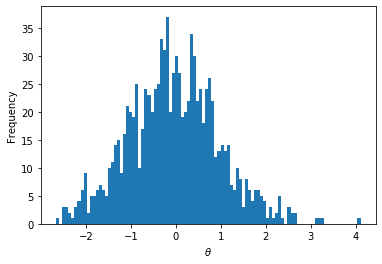

In [357]:
# Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
print(theta_exact.shape)
plt.hist(theta_exact[:, 0], 100)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

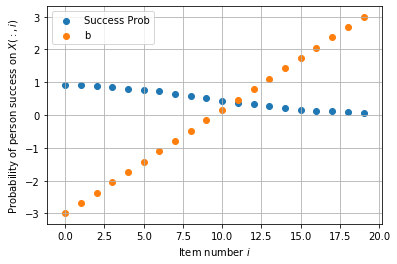

In [358]:
plt.scatter(range(I), np.sum(X, axis=0)/P, label="Success Prob")
plt.scatter(range(I), b, label="b")
plt.xlabel("Item number $i$")
plt.ylabel("Probability of person success on $X(:,i)$")
plt.legend();
plt.grid(True);

### Initial Guess for $\theta$
Initial guess for $\theta_p$: the number of standard deviations person's p's score is away from the average population score.

In [359]:
theta = nirt.likelihood.initial_guess(X, c)
theta = (theta - np.mean(theta, axis=0))/np.std(theta, axis=0)
theta_init = theta

## Sub-scale Refinement Solver
Refining the item cluster resolution during continuation steps, but keeping the IRF resolution low (4 bins only).

In [387]:
# Run iterative refinement algorithm.
# v is fixed.
recorder = nirt.run_recorder.RunRecorder()
solver = nirt.solver_item_clustering.SolverItemClustering(
    X, c, num_iterations=num_iterations, num_theta_sweeps=num_theta_sweeps, grid_method=grid_method,
    recorder=recorder, finest_resolution=16, coarsest_resolution=4,
    theta_init=theta_exact, loss=loss)

INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
INFO     1    	2    	2    	10.00  	10.0   	0.0    	0.00
INFO     2    	4    	4    	5.00   	5.0    	1.0    	0.00
INFO     3    	7    	8    	2.50   	2.5    	0.7    	0.00
INFO     4    	7    	16   	1.25   	1.2    	0.4    	0.00
INFO     5    	7    	20   	1.00   	1.0    	0.0    	0.01
INFO     Total						0.02
INFO     Trimming #neighbors to 5


In [388]:
for level in [level for level in cntree.cntree.get_clustering_levels(clustering) if level.size <= 0.5 * I]:
    print(level, level.label)

Level 0[size=1,num_neighbors=1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Level 1[size=2,num_neighbors=2] [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Level 2[size=4,num_neighbors=4] [2 2 2 2 2 2 3 3 3 3 1 1 1 1 0 0 0 0 0 0]
Level 3[size=8,num_neighbors=7] [5 5 5 4 4 4 6 6 7 7 3 3 2 2 0 0 1 1 1 1]


Item clusters are good, they correspond to items of similar difficulty in this case.

In [390]:
t = solver.solve()

INFO     Initial guess range [-3.01, 2.80] mean 0.00 std 1.00
INFO     Solving at item clustering level with 1 items 4 bins
INFO     Iteration 1/4
INFO     Iteration 2/4
INFO     Iteration 3/4
INFO     Iteration 4/4
INFO     Solving at item clustering level with 2 items 4 bins
INFO     Iteration 1/4
INFO     Iteration 2/4
INFO     Iteration 3/4
INFO     Iteration 4/4
INFO     Solving at item clustering level with 4 items 4 bins
INFO     Iteration 1/4
INFO     Iteration 2/4
INFO     Iteration 3/4
INFO     Iteration 4/4
INFO     Solving at item clustering level with 8 items 4 bins
INFO     Iteration 1/4
INFO     Iteration 2/4
INFO     Iteration 3/4
INFO     Iteration 4/4
INFO     Solving at item clustering level with 20 items 4 bins
INFO     Iteration 1/4
INFO     Iteration 2/4
INFO     Iteration 3/4
INFO     Iteration 4/4


In [391]:
# Run history: calculate the IRF error from the known parametric model.
logger.info("Initial guess / score-based estimation correlation: {:.3f}".format(
    np.corrcoef(theta_init[:, 0], theta_exact[:, 0])[0, 1]))

for k, (resolution, value) in enumerate(recorder.irf.items()):
    logger.info("#items {}".format(resolution))
    level = solver._clustering[k]
    cluster_model_irf = [
        lambda t, i=i: np.array([model_irf[j](t) for j in level[i]]).mean(0) 
        for i in range(resolution)]
    for j in range(len(value)):
        e = nirt.error.error_norm_by_item(cluster_model_irf, value[j])
        t = recorder.theta[resolution][j]
        logger.info("IRF error: {:.3f} +- {:.3f}\tt range {:.3f}, {:.3f} corr {:.3f}".format(
            e.mean(), e.std(), t.min(), t.max(), np.corrcoef(theta_exact[:, 0], t[:, 0])[0, 1]))

INFO     Initial guess / score-based estimation correlation: 0.850
INFO     #items 1
INFO     IRF error: 0.029 +- 0.000	t range -3.009, 2.796 corr 0.850
INFO     IRF error: 0.029 +- 0.000	t range -2.588, 1.825 corr 0.782
INFO     IRF error: 0.027 +- 0.000	t range -2.981, 2.727 corr 0.850
INFO     IRF error: 0.025 +- 0.000	t range -2.963, 2.656 corr 0.850
INFO     IRF error: 0.023 +- 0.000	t range -2.934, 2.571 corr 0.849
INFO     #items 2
INFO     IRF error: 0.028 +- 0.002	t range -2.929, 2.426 corr 0.846
INFO     IRF error: 0.029 +- 0.001	t range -2.940, 2.347 corr 0.842
INFO     IRF error: 0.029 +- 0.002	t range -2.948, 2.285 corr 0.839
INFO     IRF error: 0.031 +- 0.003	t range -2.962, 2.234 corr 0.836
INFO     #items 4
INFO     IRF error: 0.039 +- 0.015	t range -2.913, 2.146 corr 0.820
INFO     IRF error: 0.047 +- 0.022	t range -2.867, 2.083 corr 0.804
INFO     IRF error: 0.051 +- 0.022	t range -2.817, 2.037 corr 0.796
INFO     IRF error: 0.054 +- 0.024	t range -2.800, 2.005 corr 0

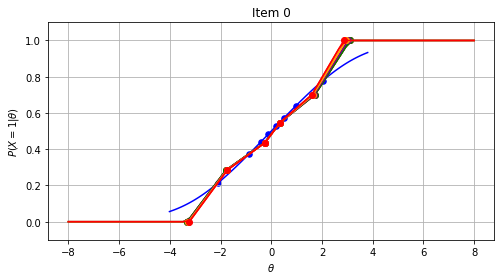

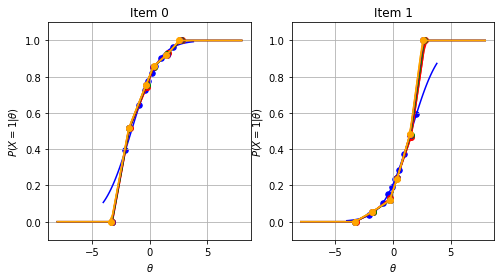

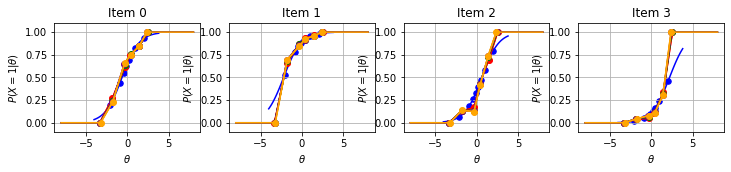

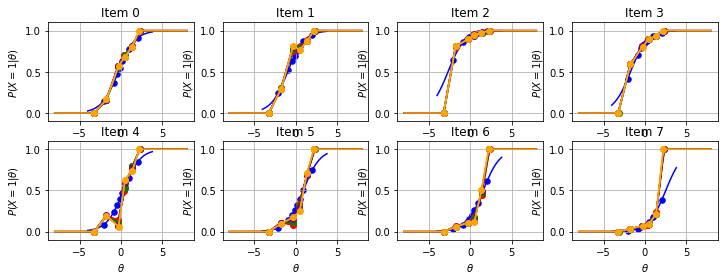

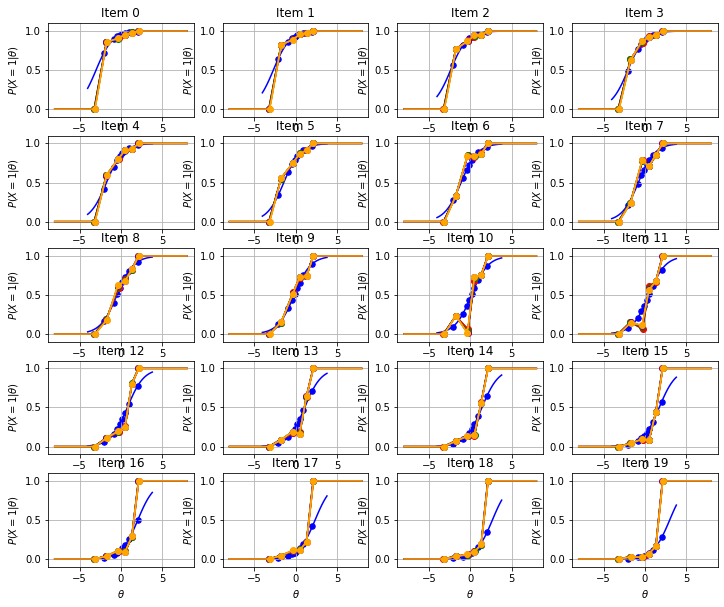

In [392]:
i = 0
item_levels = list(recorder.irf.keys())
#print("#items", item_levels)

for k, num_items in enumerate(item_levels):
    if num_items < 4:
        fig, axs = plt.subplots(1, num_items, figsize=(8, 4))
    else:
        fig, axs = plt.subplots(num_items // 4, 4, figsize=(12, 0.5 * num_items))
    cluster = solver._clustering[k]
    
    for i in range(num_items):
        ax = axs[i // 4, i % 4] if num_items > 4 else (axs[i] if num_items > 1 else axs)
        colors = ["red", "green", "purple", "orange"]
        cluster_model_irf = lambda t: np.array([model_irf[j](t) for j in cluster[i]]).mean(0)
        nirt.simulate.plot_irf.plot_model_irf(
            ax, grid_all[c[i]], cluster_model_irf, color="blue", label="Original")
        for l, irf in enumerate(recorder.irf[num_items]):
            irf[i].plot(ax, color=colors[l % len(colors)],
                        label="iter {} Error {:.2f}".format(
                            l, nirt.error.error_norm(cluster_model_irf, irf[i])))
        ax.set_title("Item {}".format(i))
        ax.grid(True)
        #ax.legend()

Some individual item IRFs have small kinks, but that's not a bad result at all.

### $\theta$ accuracy

In [393]:
print("Score-based estimate correlation: {:.3f}".format(
    np.corrcoef(theta_init[:, 0], theta_exact[:, 0])[0, 1]))
print("Final estimate correlation: {:.3f}".format(
    np.corrcoef(t[:, 0], theta_exact[:, 0])[0, 1]))

Score-based estimate correlation: 0.850
Final estimate correlation: 0.782


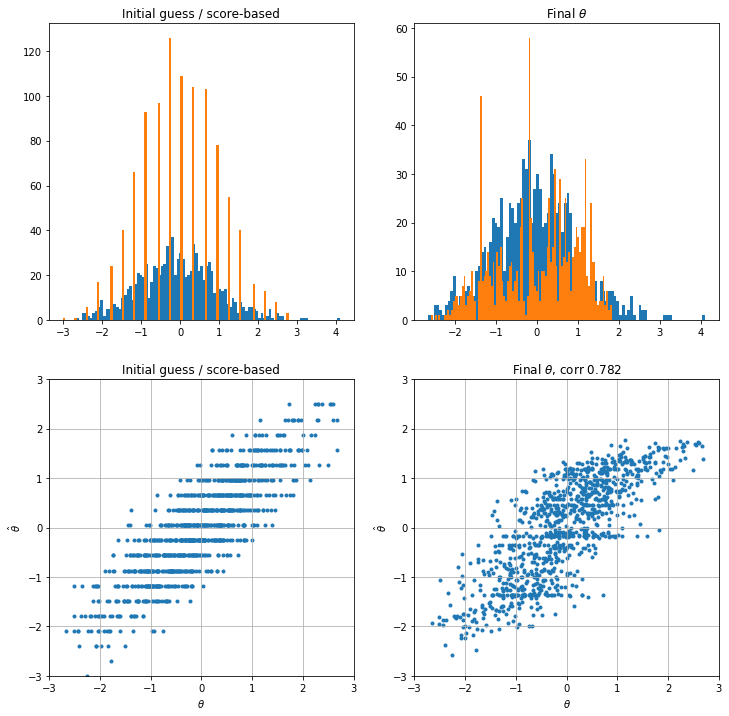

In [394]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

ax = axs[0, 0]
ax.hist(theta_exact, 100);
ax.hist(theta_init[:, 0], 100);
ax.set_title("Initial guess / score-based")


ax = axs[0, 1]
ax.hist(theta_exact, 100);
ax.hist(t[:, 0], 100);
ax.set_title(r"Final $\theta$");

ax = axs[1, 0]
ax.scatter(theta_exact[:, 0], theta_init[:, 0], marker='.');
ax.set_xlim([-3, 3]);
ax.set_ylim([-3, 3]);
ax.set_title("Initial guess / score-based".format(np.corrcoef(theta_exact[:, 0], theta_init[:, 0])[0, 1]))
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\hat{\theta}$")
ax.grid(True);

ax = axs[1, 1]
ax.scatter(theta_exact[:, 0], t[:, 0], marker='.');
ax.set_xlim([-3, 3]);
ax.set_ylim([-3, 3]);
ax.set_title(r"Final $\theta$, corr {:.3f}".format(np.corrcoef(theta_exact[:, 0], t[:, 0])[0, 1]))
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\hat{\theta}$")
ax.grid(True);

### Students with differnt $\theta$'s may have the same response pattern
So we can't hope for a corrleation $corr(\theta, \hat{\theta}) = 1$, but we should be doing better than score-based estimation.

In [395]:
score = collections.Counter([tuple(t) for t in X])
collections.Counter(score.values())

Counter({1: 721, 3: 22, 4: 6, 2: 82, 5: 5})

In [396]:
identical = np.array(
    [p for p, t in enumerate(X) 
     if np.array_equal(t, np.array([k for k, v in score.items() if v == 5][0]))])
print(identical)
print(np.concatenate((theta_exact[identical], X[identical].mean(1)[:, None], theta_init[identical], t[identical]), axis=1))

[ 56 396 400 484 945]
[[-0.635  0.35  -0.87  -0.993]
 [-0.209  0.35  -0.87  -0.993]
 [-0.883  0.35  -0.87  -0.993]
 [-1.31   0.35  -0.87  -0.993]
 [-1.336  0.35  -0.87  -0.993]]


## Subscale + IRF Resolution Refinement Solver
Refining the item cluster resolution and the IRFs at the same time during continuation steps.

## Example of $\theta_p$ Estimation using $L_2$ Loss

In [410]:
# Estimate thetas using X and the latest, individual-item IRFs.
irf = recorder.irf[20][-1]

theta_improver = nirt.theta_improvement.theta_improver_factory(
            solver._improve_theta_method, solver._num_theta_sweeps, loss=solver._loss)
likelihood = nirt.likelihood.Likelihood(X, solver.c, irf)

active = np.arange(P, dtype=int)
person_ind = np.tile(active[:, None], C).flatten()
c_ind = np.tile(np.arange(C)[None, :], len(active)).flatten()
active_ind = (person_ind, c_ind)
theta_active = theta_improver.run(likelihood, t[active], active_ind)

In [411]:
p_max = np.argmax(np.abs(theta_history[-2] - theta_history[-1]))

358 [-1.37] [-0.738] [0.156]


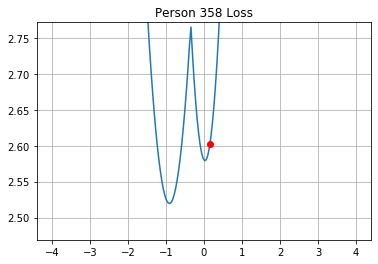

In [418]:
p = p_max

t_init = recorder.theta[20][-2][p]
print(p, theta_exact[p], t_init, theta_active[p])
xp = X[p]

alpha = 0.2
mse_loss = lambda t: sum((irf[i].interpolant(t) - xp[i]) ** 2 for i in range(len(irf))) + alpha * (t - t_init) ** 2
t_continuous = np.linspace(-4, 4, 200)
y = mse_loss(t_continuous)

plt.plot(t_continuous, y);
plt.grid(True);
#plt.xlim([-0.8, 0.2]);
plt.ylim([0.98 * min(y), 1.1 * min(y)]);

plt.plot([theta_active[p]], [mse_loss(theta_active[p])], 'ro');
plt.title("Person {} Loss".format(p));

This person's $\theta_p$ changes quite a bit during iterations, whiile other $\theta$s are more stable, because there are multiple minima of similar value.

In [414]:
np.array([recorder.theta[20][k][p] for k in range(len(recorder.theta[20]))])

array([[-0.672],
       [-0.703],
       [-0.738],
       [ 0.15 ]])

In [415]:
theta_history = np.array([recorder.theta[20][k][:, 0] for k in range(len(recorder.theta[20]))])

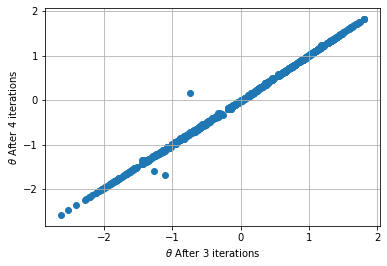

In [416]:
plt.scatter(theta_history[-2], theta_history[-1])
plt.xlabel(r"$\theta$ After {} iterations".format(num_iterations - 1))
plt.ylabel(r"$\theta$ After {} iterations".format(num_iterations))
plt.grid(True);

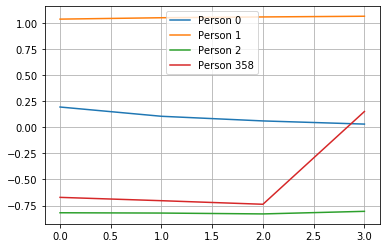

In [417]:
for p in range(3):
    plt.plot(theta_history[:, p], label="Person {}".format(p))
plt.plot(theta_history[:, p_max], label="Person {}".format(p_max))
plt.legend()
plt.grid(True);